<a href="https://colab.research.google.com/github/JakobSchauser/QNCA/blob/main/QNCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install torch_geometric


In [31]:
import torch
from torch_geometric.data import Data

In [32]:
from typing import Callable, Optional, Union

import torch
from torch import Tensor


import torch_geometric.typing
from typing import Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.utils import scatter

from torch_geometric.typing import Adj, OptTensor, PairOptTensor, PairTensor, OptPairTensor, Size
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import inspect

def print2(*msg):
    frame = inspect.currentframe().f_back
    print(f"[LINE {frame.f_lineno}]", *msg)


class CustomEdgeConv(MessagePassing):
    def __init__(self, in_features, hidden_dim, out_dim=3):
        super().__init__(aggr=None)  # no aggregation, we just compute edge outputs
        self.mlp = nn.Sequential(
            nn.Linear(in_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x, edge_index):
        # # Ensure undirected by sorting (min, max) node indices
        # src, dst = edge_index
        # undirected_edges = torch.stack([
        #     torch.min(src, dst),
        #     torch.max(src, dst)
        # ], dim=0)

        # # Remove duplicate edges
        # undirected_edges, unique_idx = torch.unique(undirected_edges, dim=1, return_inverse=True)

        # Build edge features: concat(node_u, node_v)
        u, v = edge_index
        # edge_feat = torch.cat([x[u], x[v]], dim=-1)
        edge_feat = (x[u] - x[v])

        # Predict 3 features per undirected edge
        edge_out = self.mlp(edge_feat)  # [num_undirected_edges, out_dim]

        node_out = self.edge_out_to_node_out_avg(edge_out, edge_index)

        return node_out # [num_nodes, out_dim]

    def edge_out_to_node_out_directional(self, edge_out, edge_index, reduce='sum'):
        u, v = edge_index  # u -> v (source -> target)

        # Aggregate to target nodes (incoming edges)
        node_out = scatter(edge_out, v, dim=0, dim_size=100, reduce=reduce)

        return node_out


    def edge_out_to_node_out_avg(self, edge_out, edge_index, reduce='sum'):
        u, v = edge_index  # u -> v (source -> target)

        # Aggregate to target nodes (incoming edges)
        node_out1 = scatter(edge_out, u, dim=0, dim_size=100, reduce=reduce)
        node_out2 = scatter(edge_out, v, dim=0, dim_size=100, reduce=reduce)

        return (node_out1 + node_out2)/2.


class CustomGraphConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        aggr: str = 'add',
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_rel = Linear(in_channels[0], out_channels, bias=bias)
        self.lin_root = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_rel.reset_parameters()
        self.lin_root.reset_parameters()


    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_weight: OptTensor = None, size: Size = None) -> Tensor:

        if isinstance(x, Tensor):
            x = (x, x)

        out_1 = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=size)

        # print2(out_1.shape)  # [N_cells, 3]

        out = self.lin_rel(out_1)

        x_r = out_1

        assert x_r is not None, "x_r is None"
        # if x_r is not None:
        out = out + self.lin_root(x_r)

        return out

    def message(self, x_i : Tensor, x_j :Tensor, edge_weight: OptTensor) -> Tensor:

        x = (x_j - x_i)
        # print2(x.shape) # [N_cells * N_nbs, 3])

        return x if edge_weight is None else edge_weight.view(-1, 1) * x

    # def aggregate(self, inputs, index, ptr=None, dim_size=None):
    #     return inputs, index

    # def message_and_aggregate(self, adj_t: Adj, x: OptPairTensor) -> Tensor:
    #     return spmm(adj_t, x[0], reduce=self.aggr)


class CustomGNN(torch.nn.Module):
    def __init__(self, hidden_dims,):
        super(CustomGNN, self).__init__()

        if type(hidden_dims) is not list:
            hidden_dims = [hidden_dims]


        # NN = nn.Sequential(nn.Linear(2, 6), nn.ReLU(), nn.Linear(6, 6), nn.ReLU(), nn.Linear(6, hidden_dims[0]))

        # convolutional layer
        # self.input_layer = CustomEdgeConv(NN)
        self.input_layer = CustomGraphConv(3, hidden_dims[0])

        self.hidden_layers = torch.nn.ModuleList()
        self.activation_func = F.relu

        for i in range(len(hidden_dims)-1):
            _in = hidden_dims[i]
            _out = hidden_dims[i+1]

            self.hidden_layers.append(Linear(_in, _out))

        self.output_layer = Linear(hidden_dims[-1], 3, bias = True)


    def forward(self, feature_data, edge_info):
        x = self.input_layer(feature_data, edge_info)


        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation_func(x)  # Apply activation function to each hidden layer output

        x = self.output_layer(x, )

        return x

hidden_dims = [16, 16, 16]  # Hidden dimensions

# Initialize the CustomGNN model
# model = CustomGNN(hidden_dims)
model = CustomEdgeConv(3, 16, 3)

In [33]:
import torch
from torch_geometric.data import Data
# from torch_geometric.nn import knn_graph
from torch.nn.functional import pairwise_distance
from torch_geometric.utils import to_undirected
# Define a grid of agents
num_agents = 100
grid_size = 10
x = torch.linspace(0, grid_size, steps=10)
y = torch.linspace(0, grid_size, steps=10)

positions = torch.stack(torch.meshgrid(x, y), dim=-1).view(-1, 2)

angle_feature_data = 2 * torch.pi * torch.rand(num_agents, 1)

print2(angle_feature_data.shape, positions.shape)
feature_data = torch.cat([positions[:,0].unsqueeze(1), positions[:,1].unsqueeze(1), angle_feature_data], dim=1)
print2(feature_data.shape)


# Define the graph using k-NN (manual implementation)


def knn_with_cutoff(x, k=8, cutoff=1.0, self_loops=False):
    N, D = x.shape

    # pairwise squared distances
    dist2 = torch.cdist(x, x, p=2) ** 2

    # mask self-distances (unless self_loops=True)
    if not self_loops:
        dist2.fill_diagonal_(float("inf"))

    # get k nearest neighbors
    dist, idx = torch.topk(dist2, k, largest=False)

    # cutoff mask
    mask = dist <= cutoff**2

    # source nodes (repeat each index k times)
    row = torch.arange(N, device=x.device).repeat_interleave(k)
    col = idx.reshape(-1)
    mask_flat = mask.reshape(-1)

    # # apply cutoff mask
    row = row[mask_flat]
    col = col[mask_flat]

    edge_index = torch.stack([row, col], dim=0)

    edge_index = to_undirected(edge_index, num_nodes=N)

    return edge_index

update_edge_index = lambda x: knn_with_cutoff(x, k=7, cutoff=2.0)

edge_index = update_edge_index(positions)


[LINE 16] torch.Size([100, 1]) torch.Size([100, 2])
[LINE 18] torch.Size([100, 3])


In [34]:
edge_index.shape

torch.Size([2, 662])

In [35]:
(edge_index == 21).sum(axis = 1)

tensor([8, 8])

# Task
Create a Python class that trains agents to align their "feature data" using a custom GNN with a k-nearest neighbors (KNN) graph, allowing for the use of different KNN implementations.

In [36]:
input_features = 3
model = CustomEdgeConv(input_features, 16)
x = torch.randn(num_agents, input_features)  # node embeddings

out = model(x, edge_index)

In [37]:
out.shape

torch.Size([100, 3])

In [38]:
edge_index.shape

torch.Size([2, 662])

In [39]:
def alignment_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = F.mse_loss(source_features[:,0], target_features[:,0])
    return loss


def width_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    maxx = torch.max(source_features[:,1])
    minx = torch.min(source_features[:,1])
    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = maxx - minx
    return -loss



def height_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    maxy = torch.max(source_features[:,2])
    miny = torch.min(source_features[:,2])
    # print2(target_features.shape) # shape [ncells * n_nbs, n_features]
    # Calculate mean squared error between connected nodes
    loss = maxy - miny
    return loss


def dist_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    source_positions = source_features[:,1:]
    target_positions = target_features[:,1:]

    dists = torch.linalg.norm(source_positions - target_positions, dim=1)


    # adists = torch.where(dists > 1., 1., dists)

    loss = -torch.sum(dists)

    return loss


def get_slice_area(a, b, theta):
    assert all(theta != torch.pi), "No right angles, please"

    h = b*torch.sin(theta)

    denom = (a-b/(torch.cos(theta) + 1e-10))
    assert not torch.isnan(denom).any(), "NaNs in denom"

    k = (a-b*torch.cos(theta))/ (denom + 1e-10)

    A = 1/2*h*(b*torch.sin(theta)  + h*torch.tan(theta) - k*k)

    assert not torch.isnan(A).any(), "NaNs in A"
    return A


def subtract_two_angles(angle1, angle2):
    return (angle1 - angle2 + torch.pi) % (2 * torch.pi) - torch.pi

def area_loss(output, edge_index):
    # Extract source and target node features
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    source_features = output[source_nodes]
    target_features = output[target_nodes]

    positions    = source_features[:,1:]

    nb_positions = target_features[:,1:]

    # any nans?
    assert not torch.isnan(positions).any(), "NaNs in positions"
    assert not torch.isnan(nb_positions).any(), "NaNs in nb_positions"

    midpoints = (positions + nb_positions) / 2.


    local_midpoints = midpoints - positions

    # any_nans?
    assert not torch.isnan(local_midpoints).any(), "NaNs in local_midpoints"

    dists = torch.linalg.norm(local_midpoints, dim=1)

    angles = torch.atan2(local_midpoints[:,1], local_midpoints[:,0])


    dists_reshaped = dists.view(7,100)
    angles_reshaped = angles.view(7,100)

    # any nans?
    assert not torch.isnan(dists_reshaped).any(), "NaNs in dists"
    assert not torch.isnan(angles_reshaped).any(), "NaNs in angles"

    slice_area0 = get_slice_area(dists_reshaped[0], dists_reshaped[1], subtract_two_angles(angles_reshaped[1], angles_reshaped[0]))
    slice_area1 = get_slice_area(dists_reshaped[1], dists_reshaped[2], subtract_two_angles(angles_reshaped[2], angles_reshaped[1]))
    slice_area2 = get_slice_area(dists_reshaped[2], dists_reshaped[3], subtract_two_angles(angles_reshaped[3], angles_reshaped[2]))
    slice_area3 = get_slice_area(dists_reshaped[3], dists_reshaped[4], subtract_two_angles(angles_reshaped[4], angles_reshaped[3]))
    slice_area4 = get_slice_area(dists_reshaped[4], dists_reshaped[5], subtract_two_angles(angles_reshaped[5], angles_reshaped[4]))
    slice_area5 = get_slice_area(dists_reshaped[5], dists_reshaped[6], subtract_two_angles(angles_reshaped[6], angles_reshaped[5]))
    slice_area6 = get_slice_area(dists_reshaped[6], dists_reshaped[0], subtract_two_angles(angles_reshaped[0], angles_reshaped[6]))

    slice_areas = torch.stack([slice_area0, slice_area1, slice_area2, slice_area3, slice_area4, slice_area5, slice_area6], dim=1)
    areas = torch.sum(slice_areas, dim=1)

    # any nan?
    assert not torch.isnan(areas).any(), "NaNs in areas"

    loss = -torch.mean(areas)

    # any nans?
    assert not torch.isnan(loss).any(), "NaNs in loss"

    return loss
    # print2(dists.shape)








In [40]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

## Implement the nca update rule

### Subtask:
Define a function that updates the agent's features based on the model's delta output and potentially a learning rate or other update parameters.


In [41]:
def nca_update(feature_data, delta_output, learning_rate):
    """
    Updates agent features based on the model's delta output using NCA rules.

    Args:
        feature_data (torch.Tensor): The current feature data of the agents.
        delta_output (torch.Tensor): The delta output from the CustomGNN model.
        learning_rate (float): The learning rate for updating features.

    Returns:
        torch.Tensor: The updated feature data, wrapped to [0, 2*pi].
    """
    updated_feature_data = feature_data + delta_output * learning_rate
    # Wrap the feature data to be within [0, 2*pi]
    updated_feature_data[:,0] = updated_feature_data[:,0] % (2. * torch.pi)

    return updated_feature_data

def nca_update_angles(feature_data, delta_output, learning_rate):
    """
    Updates agent features based on the model's delta output using NCA rules.

    Args:
        feature_data (torch.Tensor): The current feature data of the agents.
        delta_output (torch.Tensor): The delta output from the CustomGNN model.
        learning_rate (float): The learning rate for updating features.

    Returns:
        torch.Tensor: The updated feature data, wrapped to [0, 2*pi].
    """

    delta_output[:,1:] = 0.

    updated_feature_data = feature_data + delta_output * learning_rate
    # Wrap the feature data to be within [0, 2*pi]

    updated_feature_data[:,0] = updated_feature_data[:,0] % (2. * torch.pi)
    return updated_feature_data

## Modify the training loop for nca

### Subtask:
Create a training loop that simulates multiple NCA steps within each epoch. In each epoch, perform several forward passes of the GNN, apply the update rule, and calculate the loss based on the alignment of features *after* these update steps.


**Reasoning**:
Implement the training loop with multiple NCA steps per epoch as described in the instructions.



In [42]:
# delta_output = model(current_feature_data, edge_index)


In [43]:
nca_steps = 50  # Number of NCA steps per epoch
nca_learning_rate = 0.01 # Learning rate for the NCA update

num_epochs = 1000


for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    current_feature_data = feature_data.clone().detach().requires_grad_(True) # Start with the initial features for each epoch

    for step in range(nca_steps):
        delta_output = model(current_feature_data, edge_index)
        # any nans
        assert not torch.isnan(delta_output).any(), "NaNs in delta_output"
        # print2(delta_output.shape)
        current_feature_data = nca_update(current_feature_data, delta_output, nca_learning_rate)
        edge_index = update_edge_index(current_feature_data[:,1:])
    # Calculate loss after all NCA steps
    # loss = alignment_loss(current_feature_data, edge_index)
    loss = width_loss(current_feature_data, edge_index) + dist_loss(current_feature_data, edge_index)*10.
    # loss = height_loss(current_feature_data, edge_index) + area_loss(current_feature_data, edge_index)

    loss.backward()

    # any nans in gradients?
    assert not torch.isnan(loss).any(), "NaNs in loss"
    # assert not torch.isnan(current_feature_data.grad).any(), "NaNs in current_feature_data.grad"

    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/2000], Loss: -8216.4180
Epoch [20/2000], Loss: -8340.6328
Epoch [30/2000], Loss: -8253.1611
Epoch [40/2000], Loss: -8252.0137
Epoch [50/2000], Loss: -8288.3281
Epoch [60/2000], Loss: -8125.3555
Epoch [70/2000], Loss: -8523.9482
Epoch [80/2000], Loss: -8120.9575
Epoch [90/2000], Loss: -7986.9414
Epoch [100/2000], Loss: -8357.0371
Epoch [110/2000], Loss: -8215.5898
Epoch [120/2000], Loss: -7968.6255
Epoch [130/2000], Loss: -7917.2212
Epoch [140/2000], Loss: -7478.3042
Epoch [150/2000], Loss: -7303.7549
Epoch [160/2000], Loss: -6840.5000
Epoch [170/2000], Loss: -6959.9727
Epoch [180/2000], Loss: -6676.3394
Epoch [190/2000], Loss: -6199.3359
Epoch [200/2000], Loss: -5785.3628
Epoch [210/2000], Loss: -5855.3345
Epoch [220/2000], Loss: -5511.2959
Epoch [230/2000], Loss: -5062.9644
Epoch [240/2000], Loss: -3861.0266
Epoch [250/2000], Loss: -4054.5247
Epoch [260/2000], Loss: -3677.3311
Epoch [270/2000], Loss: -3462.6528
Epoch [280/2000], Loss: -3748.2383
Epoch [290/2000], Loss: -3558

KeyboardInterrupt: 

In [44]:
# run the nca and get history

history = []

current_feature_data = feature_data.clone().detach().requires_grad_(True) # Start with the initial features for each epoch

for step in range(nca_steps):
    delta_output = model(current_feature_data, edge_index)
    current_feature_data = nca_update(current_feature_data, delta_output, nca_learning_rate)
    edge_index = update_edge_index(current_feature_data[:,1:])
    history.append(current_feature_data.clone().detach().numpy())



In [45]:
import matplotlib.pyplot as plt
import numpy as np

In [46]:
feature_data.shape, positions.shape

(torch.Size([100, 3]), torch.Size([100, 2]))

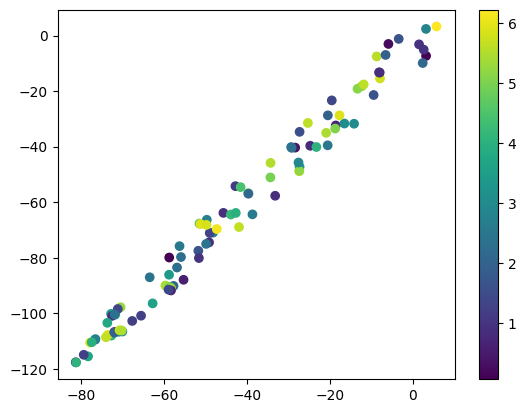

In [47]:
curdata = history[-1][:,0]
curposs = history[-1][:,1:]
startdata = history[0][:,0]


plt.scatter(curposs[:, 0], curposs[:, 1], c=curdata, cmap='viridis')

arrows = [np.cos(curdata), np.sin(curdata)]
oldarrows = [np.cos(startdata), np.sin(startdata)]

# plt.quiver(curposs[:, 0], curposs[:, 1], oldarrows[0]*0.3, oldarrows[1]*0.3, color='blue', scale=10)
# plt.quiver(curposs[:, 0], curposs[:, 1], arrows[0]*0.5, arrows[1]*0.5, color='red', scale=10)
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Assuming 'history' is a list of tensors, where each tensor is the feature data at a step
# And assuming the first column of the feature data is the angle and the rest are positions

# 100 random colors
colors = plt.cm.hsv(np.linspace(0, 1, 100))

def update(frame_index):
    plt.clf()  # Clear the current figure
    current_frame = history[frame_index]
    current_data = current_frame[:, 0]
    current_positions = current_frame[:, 1:]
    plt.scatter(current_positions[:, 0], current_positions[:, 1], c=colors, cmap='hsv')
    plt.title(f'NCA Step {frame_index}')
    plt.colorbar(label='Angle')


    center_of_mass = np.mean(current_positions, axis=0)
    # plt.xlim(-5 + center_of_mass[0], 5 + center_of_mass[0])
    # plt.ylim(-5 + center_of_mass[1], 5 + center_of_mass[1])
    x_min = np.min(current_positions[:, 0])
    x_max = np.max(current_positions[:, 0])
    y_min = np.min(current_positions[:, 1])
    y_max = np.max(current_positions[:, 1])

    w, h = x_max - x_min, y_max - y_min
    max_side = max(w, h)

    plt.xlim(center_of_mass[0] - max_side/2, center_of_mass[0] + max_side/2)
    plt.ylim(center_of_mass[1] - max_side/2, center_of_mass[1] + max_side/2)

fig = plt.figure(figsize=(7, 7))
ani = animation.FuncAnimation(fig, update, frames=len(history), repeat=False)

# To display the video inline in the notebook
HTML(ani.to_html5_video())